<a href="https://colab.research.google.com/github/TurkuNLP/register-DeepL/blob/main/register_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running this notebook put the file in the directory.

In [1]:
!wget -nc https://github.com/TurkuNLP/register-DeepL/blob/main/AfterDeepL/es_FINAL.tsv.gz # the repo is private so this does not work lol

File ‘es_FINAL.tsv.gz’ already there; not retrieving.



In [2]:
!pip3 install -q transformers datasets

In [3]:
import transformers
import datasets
import gzip 
import random
import re
import json

from pprint import PrettyPrinter
import logging
pprint = PrettyPrinter(compact=True).pprint
logging.disable(logging.INFO)

In [4]:
file_name = "es_FINAL.tsv.gz"
data=[]
with gzip.open(file_name, 'rb') as f:
    for line in f:
        line = line.decode()
        line=line.rstrip("\n")
        if not line or line.startswith("#"): #skip empty and comments (incl. header)
            continue
        cols=line.split("\t")
        if len(cols)!=2: #skip weird lines that don't have the right number of columns
            continue
        data.append(cols)

pprint(data[0])

['NA OP',
 "El martes por la noche, Sarah Palin se pasó por el programa de Bill O'Reilly "
 'para hablar de algunos comentarios recientes de Laura Ingraham, así como del '
 'enfoque que debería adoptar la candidatura de Romney/Ryan en la recta final '
 'de la campaña. Insistiendo en el argumento de que Mitt Romney debe ser más '
 'agresivo, Palin definió las elecciones como una elección entre "cosas gratis '
 'o libertad". Preguntada por el comentario de Ingraham de que si los '
 'republicanos no pueden ganar estas elecciones, deberían cerrar el partido, '
 'Palin también estuvo de acuerdo en que estas elecciones deberían favorecer a '
 'Romney. Rush Limbaugh dijo igualmente que la reelección del presidente '
 'señalaría el fin del GOP. La cuestión, dijo, es que el mensaje llegue a los '
 'votantes. "Si no puedes hacer llegar tu mensaje a través de ese filtro de '
 'los medios de comunicación, entonces estamos en un mundo de dolor", dijo. Lo '
 'que los republicanos no están haciendo, 

In [5]:
random.seed(1234) # remember to shuffle since the data is now in en,fi,swe,fre order
random.shuffle(data) 

In [6]:
# get a list of all the unique labels in the data using set which does not allow duplicates

labels = [one[0] for one in data]

#this splits all of the labels into their own thing for multilabeling
split_labels= []
for labeled in labels:
  labeleds = labeled.split()
  for label in labeleds:
    split_labels.append(label)
print(split_labels[:10])

labelset = set(split_labels) #split_labels
unique_labels=list(labelset)

# or make a label list from the picture which includes all the possibilities ? there should be 55 different but our dataset only has 43 which will do for now at least
# format of the labels? base+sub together in the label list?

texts= [one[1] for one in data]
print(len(unique_labels)) 
print(unique_labels[:10])

['DT', 'IN', 'IP', 'IN', 'HI', 'LT', 'IP', 'DS', 'MT', 'OS']
43
['ID', 'OS', 'RS', 'PB', 'LY', 'HA', 'RA', 'DF', 'SR', 'FA']


In [7]:
# split the labels into a list in the data
for i in range(len(data)):
  labeledlist = data[i][0]
  lablist = labeledlist.split()
  data[i][0] = lablist

print(data[0][0])

labels = [one[0] for one in data]
print(labels[:10])

['DT', 'IN']
[['DT', 'IN'], ['IP'], ['IN', 'HI', 'LT'], ['IP', 'DS'], ['MT', 'OS'], ['DT', 'IN'], ['IP'], ['HI'], ['IP', 'DS'], ['NA', 'IN']]


In [8]:
# indexlist = []
# line = []
# for i in range(len(data)):
#   lab = data[i][0]
#   for j in range(len(lab)):
#     line.append(unique_labels.index(lab[j]))
#   indexlist.append(line)
#   line= []
# print(indexlist[0])


# then one-hot encode all the labels in the data?
# I guess I could use pandas for this, first change everything to pandas format and then encode the labels

import pandas as pd

df = pd.DataFrame({
    "text": texts,
    "labels": labels
})
print(df)

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
yt = mlb.fit_transform(df.labels)
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
print(mlb.classes_)

                                                   text            labels
0     Otro tipo de jueves y el curso Hacia una vida ...          [DT, IN]
1     Todavía quedan algunas plazas en la próxima se...              [IP]
2     Introduce tu dirección de correo electrónico y...      [IN, HI, LT]
3     - ASUPERMALL Bolsa de almacenamiento compatibl...          [IP, DS]
4     Categorías Negocio en casa Tengo que admitir q...          [MT, OS]
...                                                 ...               ...
9262  Páginas Nov 17, 2012 Cortando tu prosa dorada ...              [NA]
9263  Lyrics Depot es tu fuente de la letra de It Ha...              [LY]
9264  ¿Qué es la idea de contactar? ¿Cuál es la idea...              [ID]
9265  Mi hermano murió hace dos años Otras preguntas...              [ID]
9266  Esperamos darle la bienvenida al Mercure Wagga...  [IP, OP, DS, RV]

[9267 rows x 2 columns]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0

In [28]:
with open("translated-register-data.jsonl", "wt") as f:
    for cols, labs in zip(data, yt):
        item = {
            "text": cols[1],
            "labels": labs.tolist() #labs #unique_labels.index(cols[0]),
             # change this to have the binary one-hot encoded list of the labels, or a list of the labels => anyway a list
        }
        print(json.dumps(item,ensure_ascii=False,sort_keys=True),file=f)

In [10]:
Dataset_ready = ""
for label in unique_labels:
  label = "\"" + label + "\""
  Dataset_ready = Dataset_ready + label +": datasets.Value(\"int64\"), "

pprint(Dataset_ready)

# this makes the dataset ready to receive encoded data

('"ID": datasets.Value("int64"), "OS": datasets.Value("int64"), "RS": '
 'datasets.Value("int64"), "PB": datasets.Value("int64"), "LY": '
 'datasets.Value("int64"), "HA": datasets.Value("int64"), "RA": '
 'datasets.Value("int64"), "DF": datasets.Value("int64"), "SR": '
 'datasets.Value("int64"), "FA": datasets.Value("int64"), "SO": '
 'datasets.Value("int64"), "IN": datasets.Value("int64"), "IP": '
 'datasets.Value("int64"), "HI": datasets.Value("int64"), "RV": '
 'datasets.Value("int64"), "NE": datasets.Value("int64"), "IT": '
 'datasets.Value("int64"), "MT": datasets.Value("int64"), "DP": '
 'datasets.Value("int64"), "FC": datasets.Value("int64"), "EN": '
 'datasets.Value("int64"), "OB": datasets.Value("int64"), "QA": '
 'datasets.Value("int64"), "DT": datasets.Value("int64"), "OA": '
 'datasets.Value("int64"), "TB": datasets.Value("int64"), "IG": '
 'datasets.Value("int64"), "NA": datasets.Value("int64"), "JD": '
 'datasets.Value("int64"), "CB": datasets.Value("int64"), "EB": '
 'da

In [29]:
file = "translated-register-data.jsonl"
dataset = datasets.load_dataset(
    'json',                             
    data_files={"everything":file}, # I need the test set from Veronika? ask Filip and Veronika
    split={
        "train":"everything[:80%]",  
        "validation":"everything[80%:90%]",   
        "test":"everything[90%:]"    
    }#,
    # features=datasets.Features({
    #     "text":datasets.Value("string")   # glad I found out that this works even without the features specifically mentioned, huggingface documentation mentioned they were optional
    # })
)

        # "labels":datasets.Sequence(datasets.ClassLabel(names=unique_labels)}), #datasets.ClassLabel(names=unique_labels), 
        # # change this somehow to take all labels into account??? => datasets.Sequence(feature={}) that should include all the label features I want to give

dataset     

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-9185a28e9a8ce78e/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 7414
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 926
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 927
    })
})

In [31]:
print(dataset["train"][0])

{'labels': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'text': 'Otro tipo de jueves y el curso Hacia una vida independiente para jóvenes forman parte del proyecto Kiinni arkeen de la Asociación de Estudiantes Diferentes de la Región de Helsinki , financiado por la Agencia Finlandesa de Financiación para la Infancia y la Juventud (RAY). El proyecto tiene una duración de tres años ( 2014 - 2016 ) y forma parte del programa de subvenciones Paikka auki de RAY. El objetivo del proyecto es desarrollar las habilidades de gestión de la vida cotidiana independiente, la educación posterior y la vida laboral de los jóvenes de entre 15 y 29 años .'}


In [ ]:
model_name = "xlm-roberta-large" # we use the xlmr for tokenizing (large)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=512,
        truncation=True, # do something else other than truncating? the texts now have max 1024 tokens
    )

dataset = dataset.map(tokenize)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

  0%|          | 0/7414 [00:00<?, ?ex/s]

  0%|          | 0/926 [00:00<?, ?ex/s]

  0%|          | 0/927 [00:00<?, ?ex/s]

In [ ]:
model = transformers.XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_labels), problem_type="multi_label_classification")

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [ ]:
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    max_steps=1500
)

In [ ]:
accuracy = datasets.load_metric("accuracy")

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)


data_collator = transformers.DataCollatorWithPadding(tokenizer)


# for the actual multilabel thing we need to use another metric
#microF1
from sklearn.metrics import precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro') # switch from binary to micro for multilabel at least
  #  acc = accuracy_score(labels, preds)
    return {
   #     'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

In [ ]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer = tokenizer,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Accuracy
100,5.584500,5.450514,0.023758
200,4.983400,5.140919,0.018359
300,4.651100,5.046966,0.037797
400,4.441500,4.937850,0.015119
500,4.207000,4.836441,0.016199
600,4.219300,4.742375,0.026998
700,4.063400,4.633110,0.176026
800,3.963700,4.564464,0.203024
900,3.887500,4.581437,0.176026
1000,3.844600,4.524286,0.180346


TrainOutput(global_step=1500, training_loss=4.158735087076823, metrics={'train_runtime': 1836.4241, 'train_samples_per_second': 6.534, 'train_steps_per_second': 0.817, 'total_flos': 3166166803887840.0, 'train_loss': 4.158735087076823, 'epoch': 1.62})

In [ ]:
eval_results = trainer.evaluate(dataset["test"])

print('Accuracy:', eval_results['eval_accuracy'])

Accuracy: 0.16181229773462782


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

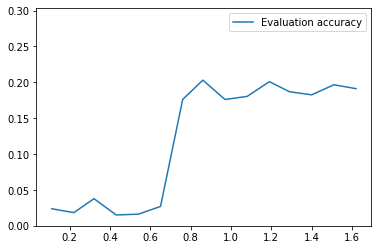

In [ ]:
plot(training_logs.logs, ["eval_accuracy"], ["Evaluation accuracy"])

I think there are several reasons this does not work at all really:



1.   The original en,fi,swe,fre datasets differ in how they put the labels in order and eng does not even have the sublabels -> thus it is impossible to be accurate when looking at a single label that is one of HOW MANY?
2.   I am also truncating it to 512 and the original texts have 1024 tokens as agreed with filip to save space when translating texts -> another way to do this?
If I am truncating then it feels unnecessary to even have translated 1024 tokens but I guess more than 512 is needed although the beginning is apparently very telling when getting the register
3.   Accuracy is also not the best metric for this because there are so many combinations -> should do true multilabel and use another metric for that
4.   And for some registers (at least lyrical) the translations might not have been as good as hoped.
5. Also maybe I should shuffle once again even though I have done that like twice before putting it through the translations.
BUT I never shuffled it after so in the file first is eng, then fi, fre, swe which might actually affect the results!!

All in all, true multilabel is the only solution to this really and even then english data only having base labels might be an issue when the others have sublabels (this also depends on the target language test set and how the annotations are done)

